In [603]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import eli5
import scipy.stats as st
from eli5.formatters.as_dataframe import explain_weights_df
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier, XGBRegressor
from category_encoders import OrdinalEncoder,OneHotEncoder
from imblearn.over_sampling import ADASYN

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, roc_auc_score, roc_curve
from sklearn.compose import TransformedTargetRegressor

import warnings
warnings.filterwarnings('ignore')

In [604]:
train = pd.read_csv('data/ALLtrainMescla5D.csv')
test = pd.read_csv('data/ALLtestMescla5D.csv')

In [605]:
df = pd.concat([train, test])
df.to_csv('data/MachineRUL.csv', index=False)
df.dtypes

machineID              int64
datetime              object
time_in_cycles         int64
voltmean_24h         float64
rotatemean_24h       float64
pressuremean_24h     float64
vibrationmean_24h    float64
voltsd_24h           float64
rotatesd_24h         float64
pressuresd_24h       float64
vibrationsd_24h      float64
voltmean_5d          float64
rotatemean_5d        float64
pressuremean_5d      float64
vibrationmean_5d     float64
voltsd_5d            float64
rotatesd_5d          float64
pressuresd_5d        float64
vibrationsd_5d       float64
error1               float64
error2               float64
error3               float64
error4               float64
error5               float64
comp1                float64
comp2                float64
comp3                float64
comp4                float64
model                 object
age                    int64
DI                   float64
RULWeek              float64
failure               object
failed                 int64
RUL           

In [606]:
df.columns[df.isna().sum() != 0] # 각 특성의 결측치가 없는 것을 확인

Index([], dtype='object')

In [607]:
df.describe(include='object').T

,count,unique,top,freq
datetime,28056,361,2015-02-21,93
model,28056,4,model3,9461
failure,28056,5,none,27579


In [608]:
df.head().T

,0,1,2,3,4
machineID,1,1,1,1,1
datetime,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10
time_in_cycles,2,3,4,5,6
voltmean_24h,171.025033,174.13941,172.135931,169.350052,171.006246
rotatemean_24h,454.614348,444.337772,446.126781,466.88409,455.695551
pressuremean_24h,102.377665,96.674842,102.097039,100.12826,99.680231
vibrationmean_24h,41.50693,41.702771,39.281983,38.571482,39.78939
voltsd_24h,17.623759,10.611608,13.829868,14.600352,12.461183
rotatesd_24h,43.648283,39.450931,38.445908,40.676186,33.0196
pressuresd_24h,8.540959,10.669844,9.558219,8.463613,9.178725


In [609]:
### Feature engineering1
# 원격센서 및 기계장비에서 추출할 수 없는 예측 데이터나 중복 되는 특성 삭제
cols = [col for col in df.columns if (('5d' in col) |('error' in col) | ('comp' in col))] 
df = df.drop(columns=cols + ['RULWeek', 'RUL', 'failure'])

In [610]:
df.columns

Index(['machineID', 'datetime', 'time_in_cycles', 'voltmean_24h',
       'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h',
       'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h', 'model', 'age',
       'DI', 'failed', 'RUL_I'],
      dtype='object')

In [611]:
# 코딩시 알아보기 쉽게 특성 rename
df.columns = ['ID','Datetime','Cycle','Voltage_mean','Rotate_mean','Pressure_mean','Vibration_mean','Voltage_sd','Rotate_sd',
              'Pressure_sd','Vibration_sd','Model','Age','DI','Failed','RUL']
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,28056.0,NaN,NaN,NaN,50.557243,28.629237,1.0,26.0,51.0,75.0,100.0
Datetime,28056,361,2015-02-21,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cycle,28056.0,NaN,NaN,NaN,166.031865,94.886557,1.0,84.0,164.0,245.0,363.0
Voltage_mean,28056.0,NaN,NaN,NaN,170.76043,4.706852,157.745683,168.055649,170.192722,172.475352,218.265191
Rotate_mean,28056.0,NaN,NaN,NaN,446.78477,17.716433,271.246607,441.536424,449.192198,456.33845,493.381312
Pressure_mean,28056.0,NaN,NaN,NaN,100.806369,4.626168,90.973896,98.660468,100.103726,101.586085,152.3146
Vibration_mean,28056.0,NaN,NaN,NaN,40.377697,2.038066,36.163723,39.368793,40.069101,40.82825,61.113082
Voltage_sd,28056.0,NaN,NaN,NaN,14.900058,2.256319,7.612362,13.33103,14.835504,16.413618,26.725027
Rotate_sd,28056.0,NaN,NaN,NaN,49.933053,7.683843,25.169282,44.685678,49.554386,54.856157,101.437628
Pressure_sd,28056.0,NaN,NaN,NaN,10.04727,1.705857,4.51385,8.92239,9.915881,10.986283,21.138799


In [612]:
### Feature engineering1
cols = ['Voltage','Rotate','Pressure','Vibration']

for col in cols:
  df[col+'_max'] = df[col+'_mean'] + df[col+'_sd']
  df[col+'_min'] = df[col+'_mean'] - df[col+'_sd']
  df.drop(columns=[col+'_sd'], inplace=True)

In [613]:
# Cycle : 작동 횟수 주기
# Voltage : 24시간 전압 평균
# Rotate : 24시간 회전 평균
# Pressure : 24시간 압력 평균
# Vibration : 24시간 진동 평균
# Error 1~5 : 1~5 종류의 Error 식별 (1일 때 식별) (범주 0,1) (drop)
# Comp 1~4 : 1~4 구성요소별 유지보수 주기 (drop)
# Model : 모델별로 나눠서 학습하기 위한 특성 (추후 drop 예정)
# Age : 기계가 얼마나 오래됬는지 (받는 데이터의 날짜를 계산해서 age 컬럼으로 받음)
# DI : 열화 지수
# Failed : 작동 멈춤 여부 (drop)
# RUL : 기계의 남은 수명 예측값 (Target 만들고 drop)
# Status : 0 = 정상, 1 = 유지보수필요, 2 = 위험

In [614]:
### Status 범위 설정
ids_list = []
for i in range(4):
  ids_list.append(df[df['Model'] == 'model' + str(i+1)]['ID'].unique())

ids_max = []
for ids in ids_list:
  id_max = []
  for id in ids:
    id_max.append(df[df['ID'] == id]['RUL'].max())
  ids_max.append(id_max)

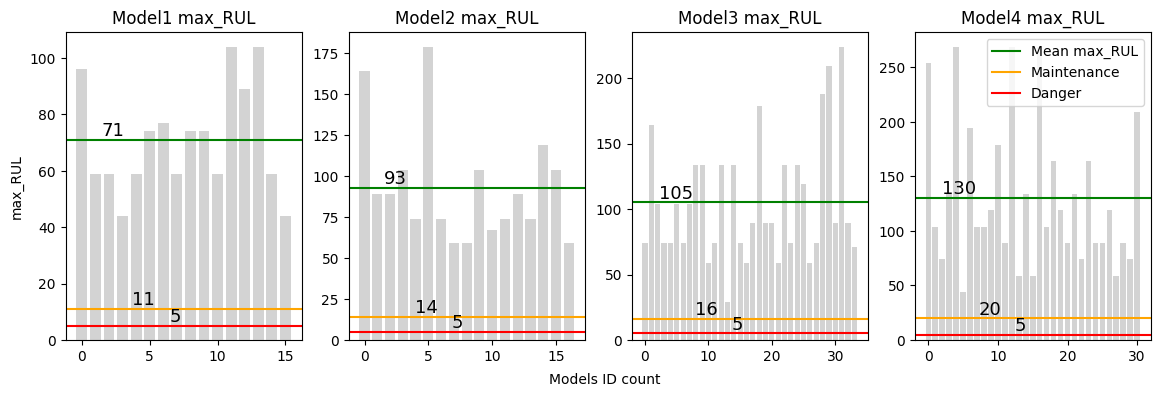

In [615]:
dang = 5 # 위험
mant_list = []
fig, ax = plt.subplots(1,4, figsize=(14,4))
for i in range(4):
  minid = np.mean(ids_max[i])
  ids_len = len(ids_max[i]) / 7
  mant = (minid * 0.15).round() # 유지보수
  mant_list.append(mant)
  
  ax[i].bar(np.arange(len(ids_max[i])), ids_max[i], color='lightgray', alpha=1)
  ax[i].set_title(f'Model{i+1} max_RUL')
  ax[i].axhline(minid, color='green', label='Mean max_RUL')
  ax[i].text(ids_len, minid, f'{minid:.0f}', fontsize=13, va='bottom', ha='center')
  ax[i].axhline(mant, color='orange', label='Maintenance')
  ax[i].text(ids_len * 2, mant, f'{(mant):.0f}', fontsize=13, va='bottom', ha='center')
  ax[i].axhline(dang, color='red', label='Danger')
  ax[i].text(ids_len * 3, dang, f'{(dang):.0f}', fontsize=13, va='bottom', ha='center')
ax[0].set_ylabel('max_RUL')
fig.text(0.47,0,'Models ID count')
plt.legend();

In [616]:
### Status 추가
df['Status'] = 0
# for i, mant in enumerate(mant_list):
#   df.loc[(df['Model'] == 'model' + str(i+1)) & (df['RUL'] <= mant), 'Status'] = 1
# df.loc[df['RUL'] <= dang, 'Status'] = 2

df.loc[df['RUL'] <= 8, 'Status'] = 1

df['Status'].value_counts()

0    23763
1     4293
Name: Status, dtype: int64

In [617]:
# plt.title('Target(Status) Distribution', fontsize=15)
# plt.pie(df['Status'].value_counts(),
#         labels=['Normal', 'Maintenance', 'Danger'],
#         colors=['limegreen', 'orange', 'orangered'],
#         autopct='%.1f%%',
#         startangle=-20,
#         wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5});

In [618]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,7179,7180,7181,7182,7183,7184,7185,7186,7187,7188
ID,1,1,1,1,1,1,1,1,1,1,...,100,100,100,100,100,100,100,100,100,100
Datetime,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,2015-01-11,2015-01-12,2015-01-13,2015-01-14,2015-01-15,...,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,2015-09-09,2015-09-10
Cycle,2,3,4,5,6,7,8,9,10,11,...,240,241,242,243,244,245,246,247,248,249
Voltage_mean,171.025033,174.13941,172.135931,169.350052,171.006246,167.40561,169.234045,170.573458,167.981092,171.307628,...,167.547444,172.355479,171.944451,170.286408,166.943738,172.077586,174.040839,183.568853,194.749947,176.556918
Rotate_mean,454.614348,444.337772,446.126781,466.88409,455.695551,433.871793,445.874333,451.978783,459.668333,471.33045,...,453.631895,432.497648,452.941488,468.804233,447.033739,434.486534,455.283708,461.623658,457.265965,442.994988
Pressure_mean,102.377665,96.674842,102.097039,100.12826,99.680231,97.453837,96.650557,102.762072,100.772665,101.683031,...,97.036428,98.159464,100.885777,99.294748,101.821737,100.517796,100.677378,99.718751,99.580578,99.89809
Vibration_mean,41.50693,41.702771,39.281983,38.571482,39.78939,41.290737,39.437964,40.140004,40.485997,40.000752,...,40.843254,40.947336,39.702889,39.132893,39.823875,37.933671,40.719428,41.277142,40.42736,42.005442
Model,model3,model3,model3,model3,model3,model3,model3,model3,model3,model3,...,model4,model4,model4,model4,model4,model4,model4,model4,model4,model4
Age,18,18,18,18,18,18,18,18,18,18,...,5,5,5,5,5,5,5,5,5,5
DI,2.66384,2.610489,2.558206,2.506971,2.456761,2.407557,2.359339,2.312086,2.26578,2.220401,...,0.458974,0.45493,0.450922,0.446949,0.443012,0.439108,0.43524,0.431405,0.427604,0.423837


In [619]:
df_corr = pd.concat([df.corr()['RUL'].sort_values(ascending=False).head(4).drop('RUL'),
                     df.corr()['RUL'].sort_values(ascending=False).tail(4).drop('Status')])
df_corr

DI             0.333408
Rotate_min     0.066604
Rotate_mean    0.062798
Failed        -0.132977
Cycle         -0.185138
Age           -0.194599
Name: RUL, dtype: float64

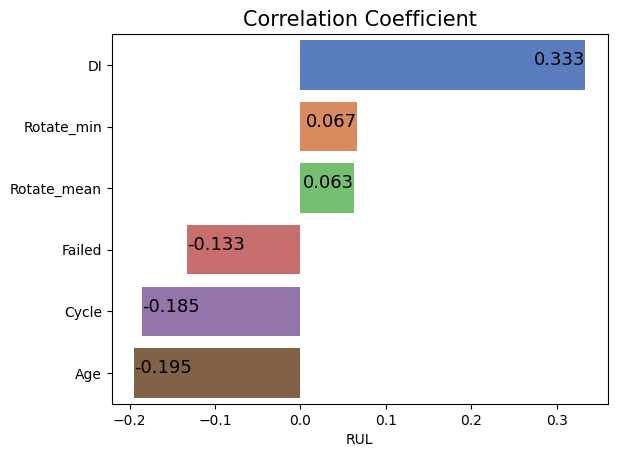

In [620]:
df_corr = pd.concat([df.corr()['RUL'].sort_values(ascending=False).head(4).drop('RUL'),
                     df.corr()['RUL'].sort_values(ascending=False).tail(4).drop('Status')])

ax = sns.barplot(x=df_corr, y=df_corr.index.to_list(), palette='muted');
ax.set_title('Correlation Coefficient', fontsize=15)
for i, p in enumerate(df_corr.to_list()):
  if p > 0:
    ax.text(p, i, f'{p:.3f}', fontsize=13, ha='right')
  else:
    ax.text(p, i, f'{p:.3f}', fontsize=13, ha='left')

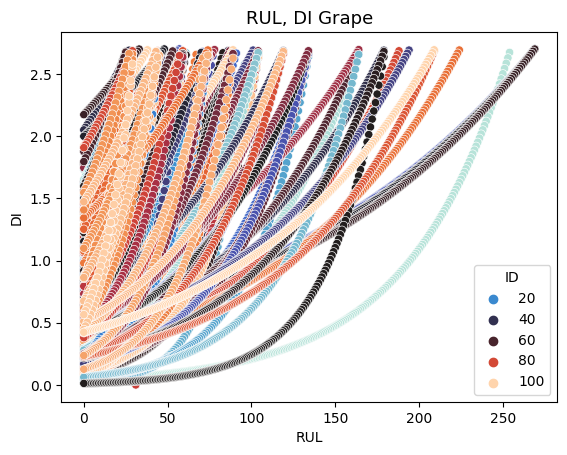

In [636]:
plt.title('RUL, DI Grape', fontsize=13)
sns.scatterplot(df, x='RUL', y='DI', hue='ID', palette='icefire');

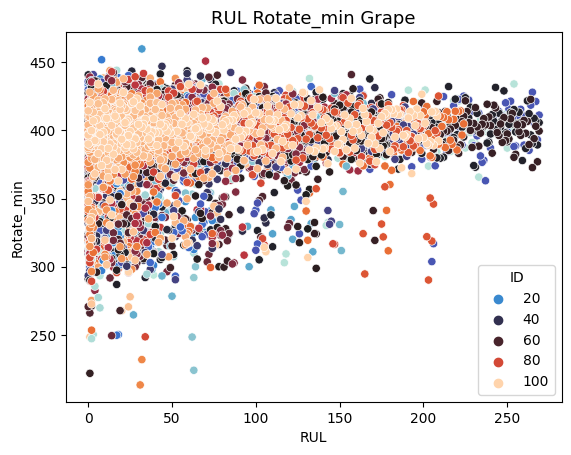

In [640]:
plt.title('RUL Rotate_min Grape', fontsize=13)
sns.scatterplot(df, x='RUL', y='Rotate_min', hue='ID', palette='icefire');

In [522]:
df_classifier = df.drop('RUL', axis=1)
df_regression = df.drop('Status', axis=1)

df_classifier.to_csv('data/RUL_classifier.csv', index=False)
df_regression.to_csv('data/RUL_regression.csv', index=False)

#### 생존 회귀 모델과 비교하기 위해 file 나눠서 코딩, 혹시몰라 dataset도 회귀, 분류로 나눔 (6차 ~ 테스트)

In [523]:
model1 = df[df['Model'] == ('model' + str(1))].reset_index(drop=True)
model2 = df[df['Model'] == ('model' + str(2))].reset_index(drop=True)
model3 = df[df['Model'] == ('model' + str(3))].reset_index(drop=True)
model4 = df[df['Model'] == ('model' + str(4))].reset_index(drop=True)

In [524]:
# model = model4.copy()

# test_id = list(model['ID'].unique()[-3:])
# train, test = model.query('ID not in @test_id'), model.query('ID in @test_id').copy()
# # train, test = train_test_split(model, train_size=0.8, random_state=42)
# # train, val = train_test_split(train, train_size=0.8, random_state=42) 교차검증 할 것

# drop_col = ['RUL', 'Model', 'Datetime', 'Failed', 'ID'] + [col for col in model.columns if (('Error' in col) | ('Comp' in col))]

# target = 'Status'

# train.drop(columns=drop_col, inplace=True)
# test.drop(columns=drop_col, inplace=True)

# train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)

# x_train = train.drop(target, axis=1)
# y_train = train[target]
# x_test = test.drop(target, axis=1)
# y_test = test[target]

# # pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2)).set_output(transform='pandas')
# # x_train = pipe.fit_transform(x_train)
# # x_test = pipe.transform(x_test)

# x_train_sam, y_train_sam = ADASYN(random_state=42, n_neighbors=3).fit_resample(x_train, y_train)

# # model = RandomForestClassifier(n_estimators=100, criterion='gini', class_weight='balanced',
# #                                max_depth=None, min_samples_split=2, min_samples_leaf=30, random_state=42)
# model = XGBClassifier(objective='multi:softmax', booster='gbtree', eval_metric='map',
#                       max_depth=10, eta=0.1, min_child_weight=1, n_estimators=100)

# scores = cross_val_score(model, x_train_sam, y_train_sam, cv=5, scoring='f1_macro')
# avg_score = np.mean(scores)
# print(scores)
# print(avg_score)

# model.fit(x_train_sam, y_train_sam)
# y_pred = model.predict(x_test)
# print(classification_report(y_test, y_pred))

In [525]:
# plt.figure(figsize=(12,4))
# plt.plot(y_pred, color='r')
# plt.plot(y_test, color='g');

In [526]:
# permuter = PermutationImportance(model, scoring='f1_macro', n_iter=5, random_state=42)
# permuter.fit(x_test, y_test)

# eli5.show_weights(permuter, top=None, feature_names=list(x_test.columns))

#### 외삽때메 아래의 Logistic을 사용하고 싶지만 성능이 안나와서 일단 보류 (3차 테스트)
#### 위의 tree 기반보다 성능이 조금은 더 좋고, 외삽을 예측할 수 있다는 점에서 로지스틱으로 다시 테스트(4~5차 테스트)

In [527]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,28056.0,NaN,NaN,NaN,50.557243,28.629237,1.0,26.0,51.0,75.0,100.0
Datetime,28056,361,2015-02-21,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cycle,28056.0,NaN,NaN,NaN,166.031865,94.886557,1.0,84.0,164.0,245.0,363.0
Voltage_mean,28056.0,NaN,NaN,NaN,170.76043,4.706852,157.745683,168.055649,170.192722,172.475352,218.265191
Rotate_mean,28056.0,NaN,NaN,NaN,446.78477,17.716433,271.246607,441.536424,449.192198,456.33845,493.381312
Pressure_mean,28056.0,NaN,NaN,NaN,100.806369,4.626168,90.973896,98.660468,100.103726,101.586085,152.3146
Vibration_mean,28056.0,NaN,NaN,NaN,40.377697,2.038066,36.163723,39.368793,40.069101,40.82825,61.113082
Model,28056,4,model3,9461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,28056.0,NaN,NaN,NaN,11.200064,5.904624,0.0,6.0,11.0,16.0,20.0
DI,28056.0,NaN,NaN,NaN,1.353352,0.687165,0.0,0.787464,1.312205,1.907928,2.701757


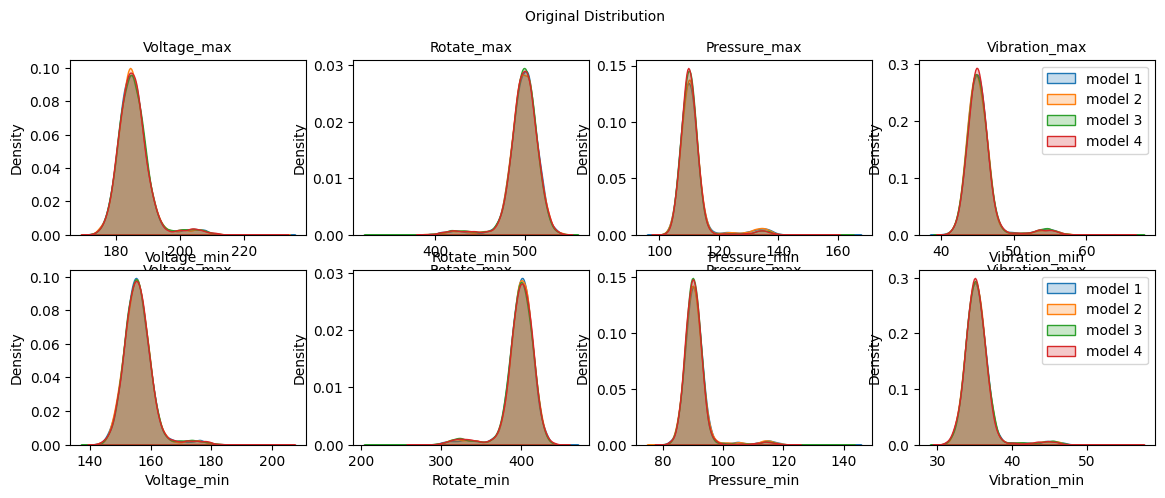

In [528]:
cols1 = ['Voltage_max', 'Rotate_max', 'Pressure_max', 'Vibration_max']
cols2 = ['Voltage_min', 'Rotate_min', 'Pressure_min', 'Vibration_min']

fig, ax = plt.subplots(2,4, figsize=(14, 5))
for j in range(1,5):
  for i, col in enumerate(cols1):
    sns.kdeplot(df.loc[df['Model'] == ('model'+str(j)), col], ax=ax[0,i], shade=True, label=f'model {j}')
    ax[0,i].set_title(col, fontsize=10)
  for i, col in enumerate(cols2):
    sns.kdeplot(df.loc[df['Model'] == ('model'+str(j)), col], ax=ax[1,i], shade=True, label=f'model {j}')
    ax[1,i].set_title(col, fontsize=10)
  ax[0,i].legend()
  ax[1,i].legend()
fig.suptitle('Original Distribution', fontsize=10);

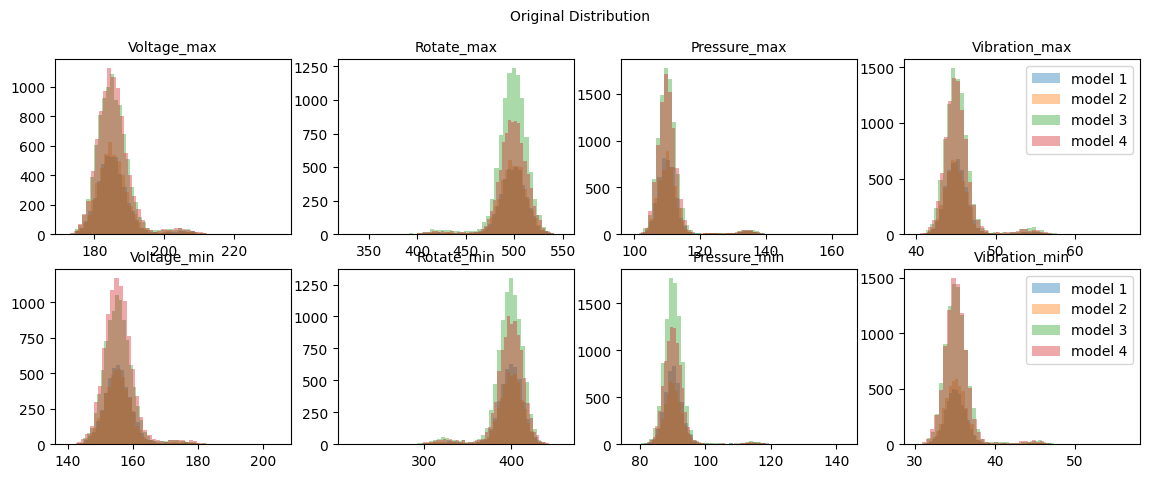

In [529]:
cols1 = ['Voltage_max', 'Rotate_max', 'Pressure_max', 'Vibration_max']
cols2 = ['Voltage_min', 'Rotate_min', 'Pressure_min', 'Vibration_min']

fig, ax = plt.subplots(2,4, figsize=(14, 5))
for j in range(1,5):
  for i, col in enumerate(cols1):
    ax[0,i].hist(df.loc[df['Model'] == ('model'+str(j)), col], alpha=.4, bins=50, label=f'model {j}')
    ax[0,i].set_title(col, fontsize=10)
  for i, col in enumerate(cols2):
    ax[1,i].hist(df.loc[df['Model'] == ('model'+str(j)), col], alpha=.4, bins=50, label=f'model {j}')
    ax[1,i].set_title(col, fontsize=10)
  ax[0,i].legend()
  ax[1,i].legend()
fig.suptitle('Original Distribution', fontsize=10);

In [530]:
cols1 = [col for col in df.columns if '_max' in col]
cols2 = [col for col in df.columns if '_min' in col]
cols3 = [col for col in df.columns if '_mean' in col]
col_list = [cols1, cols2, cols3]

def change_db(df, col_list):
  df_copy = df.copy()
  for cols in col_list:
    for col in cols:
      if 'Rotate' in col:
        df_copy[col] = np.log1p(-df_copy[col] + df_copy[col].max()) # neg skewed를 정규분포로 변환
      else:
        df_copy[col] = np.log1p(df_copy[col]) # pos skewed를 정규분포로 변환
  return df_copy

df = change_db(df, col_list)

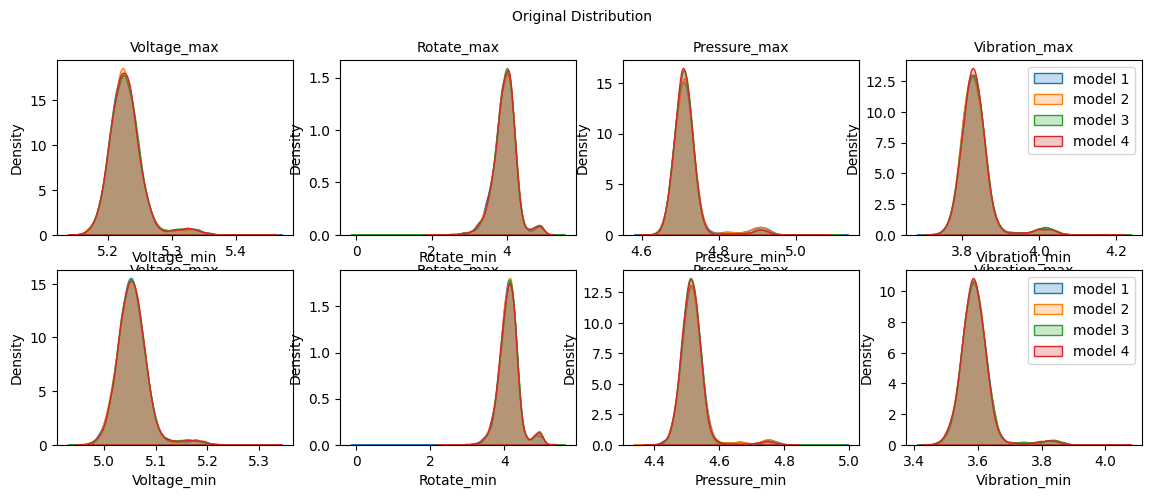

In [531]:
fig, ax = plt.subplots(2,4, figsize=(14, 5))
for j in range(1,5):
  for i, col in enumerate(cols1):
    sns.kdeplot(df.loc[df['Model'] == ('model'+str(j)), col], ax=ax[0,i], shade=True, label=f'model {j}')
    ax[0,i].set_title(col, fontsize=10)
  for i, col in enumerate(cols2):
    sns.kdeplot(df.loc[df['Model'] == ('model'+str(j)), col], ax=ax[1,i], shade=True, label=f'model {j}')
    ax[1,i].set_title(col, fontsize=10)
  ax[0,i].legend()
  ax[1,i].legend()
fig.suptitle('Original Distribution', fontsize=10);

In [555]:
# BaseModel
def base_fit(model):
  model = model
  np.random.seed(42)
  test_id_list = []
  for i in range(1,5):
    ids = list(np.random.choice(df.loc[df['Model'] == 'model' + str(1), 'ID'].unique(), 3))
    test_id_list += ids
  train, test = model.query('ID not in @test_id_list'), model.query('ID in @test_id_list').copy()

  drop_col = ['Status','Datetime', 'ID']

  target = 'RUL'

  train.drop(columns=drop_col, inplace=True)
  test.drop(columns=drop_col, inplace=True)

  train.reset_index(drop=True, inplace=True)
  test.reset_index(drop=True, inplace=True)

  x_train = train.drop(target, axis=1)
  y_train = train[target]
  x_test = test.drop(target, axis=1)
  y_test = test[target]

  pipe = make_pipeline(OrdinalEncoder(), StandardScaler(), PolynomialFeatures(degree=2)).set_output(transform='pandas')
  x_train = pipe.fit_transform(x_train)
  x_test = pipe.transform(x_test)

  model = DecisionTreeRegressor()
  scores = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
  avg_score = -np.mean(scores)
  print(scores)
  print(avg_score)

  model.fit(x_train, y_train)
  y_train_pred = model.predict(x_train)
  train_score = mean_absolute_error(y_train, y_train_pred)
  y_pred = model.predict(x_test)

  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  
  eval_scores = pd.Series([train_score, avg_score, mse, rmse, mae, r2],
                          index=['Train', 'CV average', 'MSE', 'RMSE', 'MAE', 'R2'])
  print(eval_scores)
  
  return model, x_train, y_test, y_pred, eval_scores

In [556]:
reg_model1, x_train1, y_real1, y_pred1, eval1 = base_fit(df)

[-32.82111264 -30.91407786 -36.00255604 -24.56036178 -32.95123869]
31.44986940178371
Train            0.000000
CV average      31.449869
MSE           1849.884952
RMSE            43.010289
MAE             27.072000
R2              -5.303972
dtype: float64


In [ ]:
# models_eval = pd.concat([eval1, eval2, eval3, eval4], axis=1).rename(columns={0:'Model1', 1:'Model2', 2:'Model3', 3:'Model4'})
# models_eval.round(2)

In [553]:
def pred_plot(y_real, y_pred, i, threshold):
  plt.figure(figsize=(12,3))
  plt.plot(y_pred, color='r', alpha=.7, label='Predict')
  plt.plot(y_real, color='b', label='Real')
  plt.axhline(threshold, color='orange', label='MAE')
  plt.title(f'Base Model Predict')
  plt.xlabel('List RUL Cycles')
  plt.ylabel('RUL')
  plt.legend()
  plt.show()

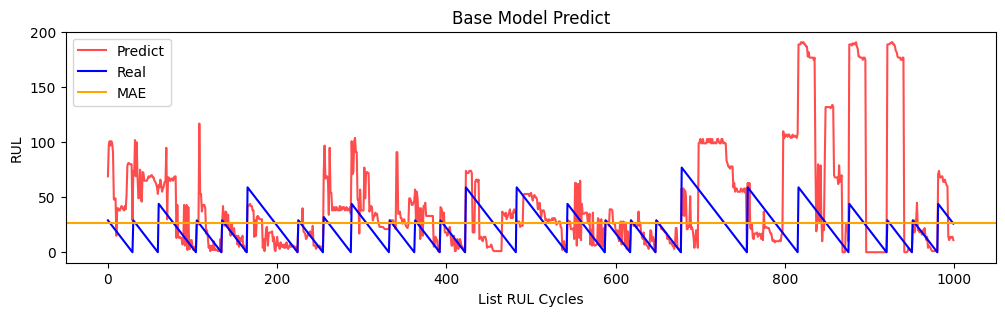

In [554]:
pred_plot(y_real1[:1000], y_pred1[:1000], 1, 27)

In [1463]:
model = model4.copy()

test_id = list(model['ID'].unique()[-3:])
train, test = model.query('ID not in @test_id'), model.query('ID in @test_id').copy()
# train, test = train_test_split(model, train_size=0.8, random_state=42)
# train, val = train_test_split(train, train_size=0.8, random_state=42) 교차검증 할 것

drop_col = ['RUL', 'Model', 'Datetime', 'ID']

target = 'Status'

train.drop(columns=drop_col, inplace=True)
test.drop(columns=drop_col, inplace=True)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

x_train = train.drop(target, axis=1)
y_train = train[target]
x_test = test.drop(target, axis=1)
y_test = test[target]

# pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2)).set_output(transform='pandas')
pipe = make_pipeline(RobustScaler(), PolynomialFeatures(degree=2)).set_output(transform='pandas')
x_train = pipe.fit_transform(x_train)
x_test = pipe.transform(x_test)

x_train_sam, y_train_sam = ADASYN(random_state=42, n_neighbors=5).fit_resample(x_train, y_train)

model = LogisticRegressionCV(cv=5, scoring='f1_macro', multi_class='multinomial', random_state=42,
                             penalty='l2', Cs=10, max_iter=10, class_weight='balanced')
scores = cross_val_score(model, x_train_sam, y_train_sam, cv=5, scoring='f1_macro')
avg_score = np.mean(scores)
print(scores)
print(avg_score)

model.fit(x_train_sam, y_train_sam)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

[0.55777224 0.56355967 0.54194806 0.60811098 0.5544152 ]
0.5651612302774065
              precision    recall  f1-score   support

           0       0.87      0.56      0.68       658
           1       0.34      0.56      0.42       224
           2       0.28      0.64      0.39        70

    accuracy                           0.56       952
   macro avg       0.50      0.59      0.50       952
weighted avg       0.70      0.56      0.60       952



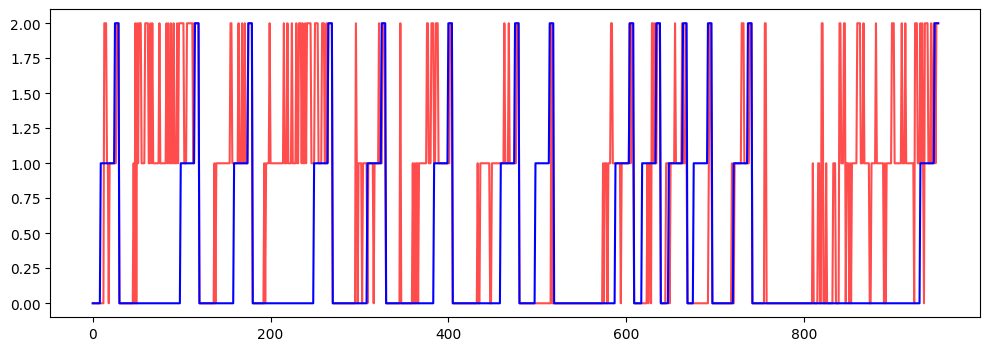

In [1468]:
plt.figure(figsize=(12,4))
plt.plot(y_pred, color='r', alpha=.7);
plt.plot(y_test, color='b');

In [1098]:
permuter = PermutationImportance(model, scoring='f1_macro', n_iter=5, random_state=42)
permuter.fit(x_test, y_test)

eli5.show_weights(permuter, top=None, feature_names=list(x_test.columns))

Weight,Feature
0.0883 ± 0.0389,DI
0.0513 ± 0.0118,Cycle^2
0.0329 ± 0.0106,Voltage_min
0.0262 ± 0.0095,Voltage_max^2
0.0239 ± 0.0078,Rotate_min^2
0.0197 ± 0.0043,Voltage_max Voltage_min
0.0168 ± 0.0109,Pressure_max Pressure_min
0.0161 ± 0.0077,Pressure_min^2
0.0156 ± 0.0119,Age Vibration_max
0.0139 ± 0.0132,Vibration_max Vibration_min


#### 아래의 코드 실행 결과. 선형, 트리 회귀로 풀기는 어렵다고 판단 (진동, 압력, 전압, 회전 특성으로는 정확한 RUL을 예측하기 힘듬) (2차 테스트)
#### 유지보수가 필요한 시점을 정해서 3단계로 나눌 것 (정상, 유지보수 필요, 위험) 다중분류

In [496]:
model = model4.copy()

test_id = list(model['ID'].unique()[-3:])
train, test = model.query('ID not in @test_id'), model.query('ID in @test_id').copy()
# train, test = train_test_split(model, train_size=0.8, random_state=42)
train, val = train_test_split(train, train_size=0.8, random_state=42)

drop_col = ['Model', 'Datetime', 'Failed', 'ID'] + [col for col in model.columns if (('Error' in col) | ('Comp' in col))]

train.drop(columns=drop_col, inplace=True)
val.drop(columns=drop_col, inplace=True)
test.drop(columns=drop_col, inplace=True)

train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

x_train = train.drop('RUL', axis=1)
y_train = train['RUL']
x_val = val.drop('RUL', axis=1)
y_val = val['RUL']
x_test = test.drop('RUL', axis=1)
y_test = test['RUL']

pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3)).set_output(transform='pandas')
x_train = pipe.fit_transform(x_train)
x_val = pipe.transform(x_val)
x_test = pipe.transform(x_test)

model = XGBRegressor(objective='reg:squarederror', eval_metric='mae', booster='gblinear', n_estimators=300, random_state=42,
                     reg_lambda=0, alpha=0, updater='coord_descent', feature_selector='cyclic')
# model = XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=100, random_state=42,
#                      max_depth=10, min_child_weight=30, learning_rate=0.1,
#                      reg_lambda=0, reg_alpha=0)
# model = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
# model = RidgeCV(scoring='neg_mean_absolute_error', cv=3, alphas=(0.1, 0.5, 1, 5, 10))
# model = LassoCV(random_state=42, cv=3, alphas=(0.1, 0.5, 1, 5, 10))
# model = LinearRegression()
model.fit(x_train, y_train)

y_val_pred = model.predict(x_val)
  
print('RMSE :', np.sqrt(mean_squared_error(y_val, y_val_pred)))
print('MAE :', mean_absolute_error(y_val, y_val_pred))
print('R2 :', r2_score(y_val, y_val_pred), '\n')

y_test_pred = model.predict(x_test)
  
print('RMSE :', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MAE :', mean_absolute_error(y_test, y_test_pred))
print('R2 :', r2_score(y_test, y_test_pred))

RMSE : 34.51789008608096
MAE : 23.73974600976652
R2 : 0.5427121282055132 

RMSE : 26.96744571835005
MAE : 19.63219945295518
R2 : 0.6557563239181788


In [497]:
# a = y_test[y_test < 10].reset_index(drop=True)
# idx = y_test[y_test < 10].index
# b = pd.Series(y_test_pred[idx]).reset_index(drop=True)

# pd.concat([a,b], axis=1)

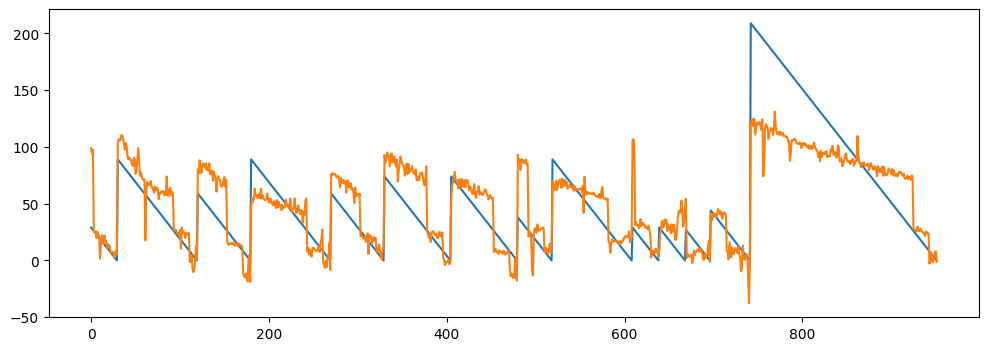

In [498]:
plt.figure(figsize=(12,4))
plt.plot(y_test)
plt.plot(y_test_pred);

In [ ]:
# permuter = PermutationImportance(model, scoring='neg_mean_absolute_error', n_iter=5, random_state=42)
# permuter.fit(x_test, y_test)

# pi = explain_weights_df(permuter, feature_names=x_test.columns.to_list())
# pi.style.background_gradient(cmap='Greens')

#### 아래의 코드는 train_test_split으로 섞지 않은 결과 (1차 테스트)

In [500]:
def model_train_test_split(df, i):
  # 모델별 예측을 위한 split
  model = df[df['Model'] == ('model' + str(i))].reset_index(drop=True)
  
  # model = model.sort_values(by='RUL', ascending=False).reset_index(drop=True)
  
  # 장비 3개로 val, test
  val_id = list(model['ID'].unique()[:3])
  test_id = list(model['ID'].unique()[-3:])
  train_not = val_id + test_id
  train = model.query('ID not in @train_not').reset_index(drop=True)
  val = model.query('ID in @val_id').reset_index(drop=True)
  test = model.query('ID in @test_id').reset_index(drop=True)
  
  target = 'RUL'
  X_train, y_train = train.drop(target, axis=1), train[target]
  X_val, y_val = val.drop(target, axis=1), val[target]
  X_test, y_test = test.drop(target, axis=1), test[target]
  return X_train, X_val, X_test, y_train, y_val, y_test

In [501]:
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1 = model_train_test_split(df, 1)
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2 = model_train_test_split(df, 2)
X_train3, X_val3, X_test3, y_train3, y_val3, y_test3 = model_train_test_split(df, 3)
X_train4, X_val4, X_test4, y_train4, y_val4, y_test4 = model_train_test_split(df, 4)

print('model1.shape :', X_train1.shape, X_val1.shape, X_test1.shape)
print('model2.shape :', X_train2.shape, X_val2.shape, X_test2.shape)
print('model3.shape :', X_train3.shape, X_val3.shape, X_test3.shape)
print('model4.shape :', X_train4.shape, X_val4.shape, X_test4.shape)

model1.shape : (2832, 21) (877, 21) (736, 21)
model2.shape : (3157, 21) (885, 21) (835, 21)
model3.shape : (7780, 21) (945, 21) (736, 21)
model4.shape : (7333, 21) (988, 21) (952, 21)


In [502]:
def eng_scale(train, val, test):
  drop_col = ['Model', 'Datetime']
  # cols = [col for col in train.columns if (('Error' in col) | ('Comp' in col))]
  train = train.copy().drop(columns=drop_col)
  val = val.copy().drop(columns=drop_col)
  test = test.copy().drop(columns=drop_col)
  
  # scale = StandardScaler().set_output(transform='pandas')
  # train = scale.fit_transform(train)
  # val = scale.transform(val)
  # test = scale.transform(test)
  
  pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2)).set_output(transform='pandas')
  train = pipe.fit_transform(train)
  val = pipe.transform(val)
  test = pipe.transform(test)
  
  return train, val, test

In [503]:
X_train1, X_val1, X_test1 = eng_scale(X_train1, X_val1, X_test1)
X_train2, X_val2, X_test2 = eng_scale(X_train2, X_val2, X_test2)
X_train3, X_val3, X_test3 = eng_scale(X_train3, X_val3, X_test3)
X_train4, X_val4, X_test4 = eng_scale(X_train4, X_val4, X_test4)

In [504]:
# mse = XGBRegressor(objective='reg:squarederror')
# rmse = XGBRegressor(objective='reg:squaredlogerror')
model = XGBRegressor(objective='reg:squarederror', booster='gblinear', random_state=42)

In [505]:
def fit_score(model, X_train, y_train, X_val, y_val):
  model.fit(X_train, y_train)
  
  # ttr = TransformedTargetRegressor(regressor=model, func=np.log1p, inverse_func=np.expm1)
  # ttr.fit(X_train, y_train)
  # y_pred = ttr.predict(X_val)
  
  y_pred = model.predict(X_val)
  
  print('RMSE :', np.sqrt(mean_squared_error(y_val, y_pred)))
  print('MAE :', mean_absolute_error(y_val, y_pred))
  print('R2 :', r2_score(y_val, y_pred))
  
  return y_pred

RMSE : 51.35951712281926
MAE : 37.436068000943074
R2 : 0.2585727778865491


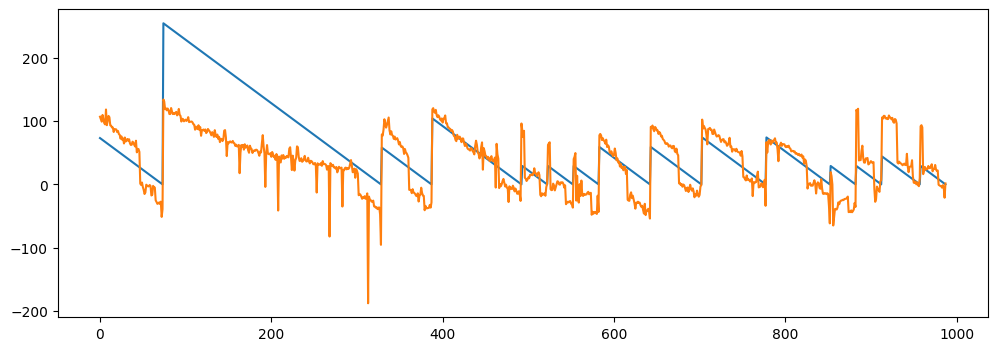

In [506]:
y_pred = fit_score(model, X_train4, y_train4, X_val4, y_val4)
plt.figure(figsize=(12,4))
plt.plot(y_val4)
plt.plot(y_pred);

In [507]:
pd.concat([y_val4, pd.Series(y_pred)],axis=1)

,RUL,0
0,73.0,106.677078
1,72.0,102.783401
2,71.0,98.863770
3,70.0,109.429474
4,69.0,102.359016
...,...,...
983,4.0,-5.212204
984,3.0,-1.297621
985,2.0,-5.166496
986,1.0,-21.061584
